# Stablecoin Simulation

---

This notebook is part of a stablecoin project.

---

# Table of Contents

1. [System Requirements](#1.-System-Requirements)
  * [Requirements Analysis](#Requirements-Analysis)
  * [Visual System Mappings](#Visual-System-Mappings)
  * [Mathematical Specification](#Mathematical-Specification)


2. [System Design](#2.-System-Design)
  * [Differential Specification](#Differential-Specification)
  * [Modelling](#Modelling)
  * [Simulation](#Simulation)


---

# 1. System Requirements

## Requirements Analysis

**Goal:** Simulate a simple collateral-backed stablecoin and examine the effects of external price shocks

**Scope:** Showcasing how simulations can offer insights into specific dynamics

**Question:** How do price shocks affect vault liquidations?

**Assumptions:**
- The price of the underlying collateral asset follows a simple stochastic process
- The _Vault Owners_ maintain their vault positions following a certain strategy
- Liquidations are triggered immediately and the collateral flows into the so called _Residual Ecosystem_

## Visual System Mappings

#### Entity Relationship Diagram

TODO

#### Stock & Flow Diagram

TODO

## Mathematical Specification

TODO

---

# 2. System Design

## Differential Specification

TODO

## Modelling

In [1]:
##############
# 0. IMPORTS #
##############

# Standard libraries
import numpy as np
import copy

# model
from model.state_variables import set_initial_state

# Analysis and plotting modules
import pandas as pd
import plotly.express as px

# radCAD modules
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend


In [2]:
################
# 0 PARAMETERS #
################

INITIAL_COLL_PRICE = 3000
NUM_OWNERS = 100
MIN_COLL_RATIO = 1.5
LIQUIDATION_RATIO = 1/MIN_COLL_RATIO

# RISKY, RISK-AVERSE, PASSIVE, IRRATIONAL
STRATEGY_DISTRIBUTION = [0.5, 0.1, 0.35, 0.05]



In [3]:
######################
# 1. STATE VARIABLES #
######################

initial_state = set_initial_state(INITIAL_COLL_PRICE, NUM_OWNERS, LIQUIDATION_RATIO, STRATEGY_DISTRIBUTION)
initial_state

########################
# 2. SYSTEM PARAMETERS #
########################

system_params = {
    "initial_coll_price": [INITIAL_COLL_PRICE],
    "num_owners": [NUM_OWNERS],
    "liquidation_ratio": [LIQUIDATION_RATIO],
    "stability_fee": [0.05],
    
    # Price simulation parameters, values are defined per year
    "coll_price_drift": [0.2],
    "coll_price_vol": [0.3],
    "jump_rate": [0.25],
    "jump_param_a": [0.1],
    "jump_param_b": [0.2],
}

<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
/var/folders/1l/jpvj4xhs17x5ylkrxzvqgxpm0000gn/T/ipykernel_10148/2368950825.py:37: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set(title="Monte Carlo simulated stock price paths in Merton's jump diffusion model\n$S_0$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, $b$ = {}, $\lambda$ = {}, timesteps = {}, num_paths = {}".format(100, price_params["coll_price_drift"], price_params["coll_price_vol"], price_params["jump_param_a"], price_params["jump_param_b"], price_params["jump_rate"], timesteps, num_paths), xlabel='Time (days)', ylabel='Stock price')


<Figure size 640x480 with 0 Axes>

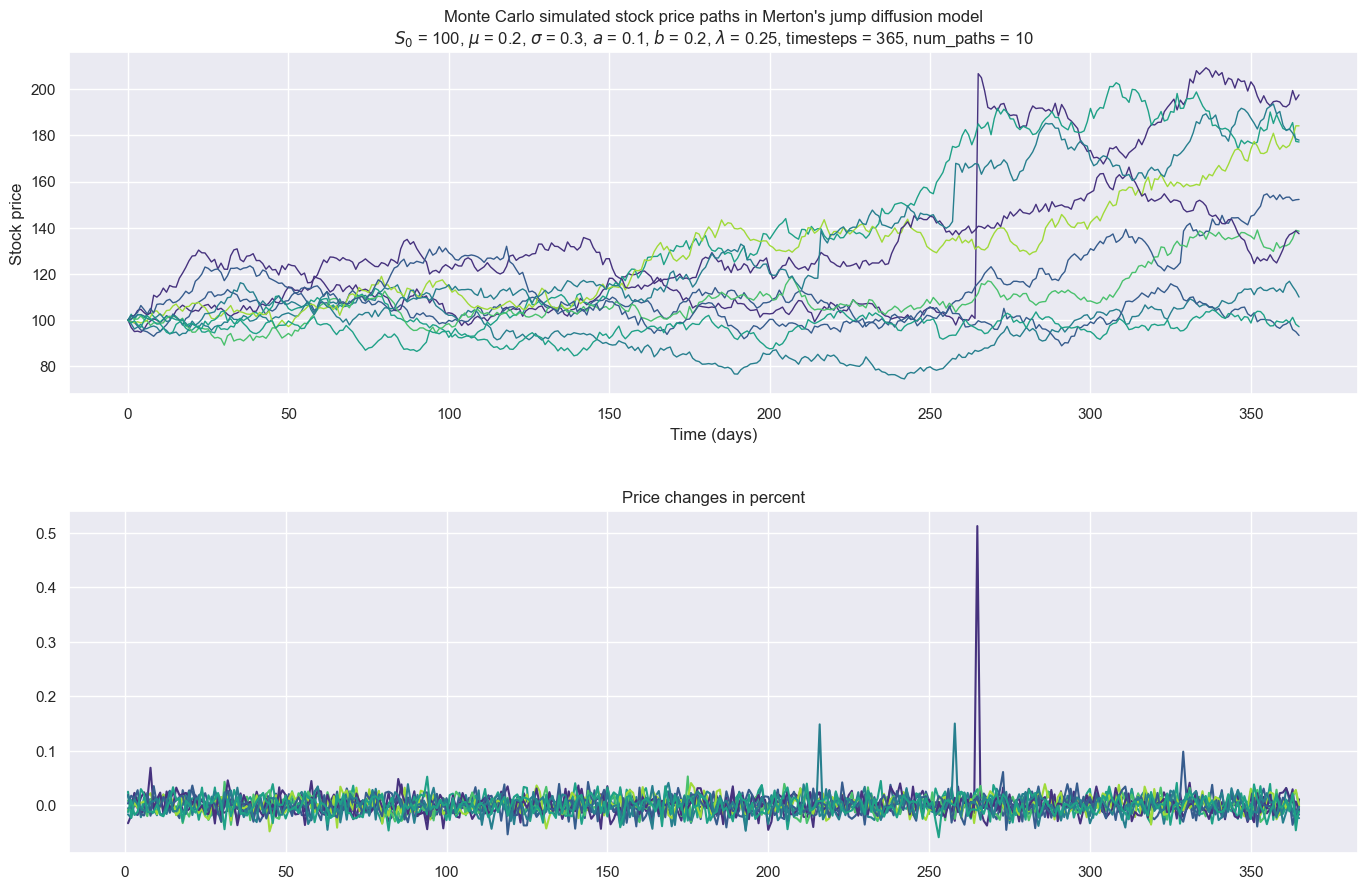

In [4]:
# This section is just to examine the jump diffusion price process

from utils.price_simulation import jump_diffusion
import matplotlib.pyplot as plt
import seaborn as sns

num_paths = 10
timesteps = 365
price_params = {
    "coll_price_drift": 0.2,
    "coll_price_vol": 0.3,
    "jump_rate": 0.25,
    "jump_param_a": 0.1,
    "jump_param_b": 0.2,
}
simulated_price_paths = jump_diffusion(100, price_params, num_paths=num_paths, timesteps=timesteps)
simulated_price_changes = np.diff(simulated_price_paths) / simulated_price_paths[:, 1:]

# Choose palette, figure size, and define figure axes
sns.set_theme(palette='viridis')
plt.figure()
width = 15
height = 10
plt.rcParams['figure.figsize'] = [width, height]
fig, ax = plt.subplots(2,1)
fig.tight_layout(pad=5.0)

t = np.linspace(0, timesteps, timesteps+1)

price_path = ax[0].plot(t, simulated_price_paths.transpose());
price_changes = ax[1].plot(t[1:], simulated_price_changes.transpose());

# Make drawn paths thinner by decreasing line width
plt.setp(price_path, linewidth=1);

# Set title (LaTeX notation) and x- and y- labels
ax[0].set(title="Monte Carlo simulated stock price paths in Merton's jump diffusion model\n$S_0$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, $b$ = {}, $\lambda$ = {}, timesteps = {}, num_paths = {}".format(100, price_params["coll_price_drift"], price_params["coll_price_vol"], price_params["jump_param_a"], price_params["jump_param_b"], price_params["jump_rate"], timesteps, num_paths), xlabel='Time (days)', ylabel='Stock price')
ax[1].set(title="Price changes in percent")

plt.show()

In [5]:

##################################
# 5. PARTIAL STATE UPDATE BLOCKS #
##################################

from model.policy_functions import p_coll_price, p_liquidation, p_vault_management
from model.state_update_functions import s_collateral, s_owners, s_stability_pool


state_update_blocks = [
    {
        'policies': {
            'coll_price': p_coll_price
        },
        'variables': {
            'collateral': s_collateral,
        }
    },
    {
        'policies': {'liquidation': p_liquidation},
        'variables': {
            'stability_pool': s_stability_pool,
            'owners': s_owners
        }
    },
        {
        'policies': {'vault_management': p_vault_management},
        'variables': {
            'stability_pool': s_stability_pool,
            'owners': s_owners
        }
    }
]

## Simulation

In [6]:
####################
# 6. CONFIGURATION #
####################

model = Model(
    initial_state=initial_state,
    state_update_blocks=state_update_blocks,
    params=system_params
)

simulation = Simulation(
    model=model,
    timesteps=300,  # Number of timesteps
    runs=10  # Number of Monte Carlo Runs
)

experiment = Experiment([simulation])
# Select the Pathos backend to avoid issues with multiprocessing and Jupyter Notebooks
experiment.engine = Engine(backend=Backend.PATHOS, drop_substeps=True)


################
# 7. EXECUTION #
################

raw_result = experiment.run()

In [7]:
####################################
# 8. SIMULATION OUTPUT PREPARATION #
####################################

from utils.metrics import  debt_collateral_ratio, num_liquidations

owner_number = 0

simulation_result = pd.DataFrame(raw_result)

simulation_result['coll_price'] = [t.price for t in simulation_result['collateral']]
simulation_result['coll_price_change'] = simulation_result['coll_price'].pct_change()
simulation_result['stability_pool_balance'] = [t.stable_coin_balance for t in simulation_result['stability_pool']]
simulation_result['num_liquidations'] = [num_liquidations(t) for t in simulation_result['owners']] 
simulation_result['debt_collateral_ratio'] = [debt_collateral_ratio(owners=t, coll_price=coll_price) for (t, coll_price) in zip(simulation_result['owners'], simulation_result["coll_price"])] 
simulation_result['vault_collateral'] = [t[owner_number].vault.collateral_balance for t in simulation_result['owners']]
simulation_result['vault_debt'] = [t[owner_number].vault.debt_balance for t in simulation_result['owners']]
simulation_result['wallet_collateral'] = [t[owner_number].wallet.collateral_balance for t in simulation_result['owners']]
simulation_result['wallet_stable_coin'] = [t[owner_number].wallet.stable_coin_balance for t in simulation_result['owners']]
simulation_result.drop(columns=['owners', 'collateral', 'stability_pool'], inplace=True)

simulation_result.head(10)

,simulation,subset,run,substep,timestep,coll_price,coll_price_change,stability_pool_balance,num_liquidations,debt_collateral_ratio,vault_collateral,vault_debt,wallet_collateral,wallet_stable_coin
0,0,0,1,0,0,3000.000000,NaN,2.472619e+07,0,0.476768,326.265982,433694.557070,5.451931,146724.057567
1,0,0,1,3,1,2956.456711,-0.014514,2.550809e+07,0,0.522376,326.265982,578754.751827,15.695213,254247.421206
2,0,0,1,3,2,2899.655359,-0.019213,2.550809e+07,0,0.533632,326.265982,578754.751827,15.695213,254247.421206
3,0,0,1,3,3,2866.946077,-0.011280,2.550809e+07,0,0.537013,326.265982,578754.751827,15.695213,254247.421206
4,0,0,1,3,4,2849.900659,-0.005945,2.550846e+07,0,0.540148,326.265982,578754.751827,15.695213,254247.421206
5,0,0,1,3,5,2803.513426,-0.016277,2.550846e+07,0,0.545704,326.265982,578754.751827,15.695213,254247.421206
6,0,0,1,3,6,2820.070814,0.005906,2.550846e+07,0,0.542476,326.265982,578754.751827,15.695213,254247.421206
7,0,0,1,3,7,2828.225413,0.002892,2.550846e+07,0,0.541420,326.265982,578754.751827,15.695213,254247.421206
8,0,0,1,3,8,2755.470078,-0.025725,2.550846e+07,0,0.540333,341.961196,565358.305430,0.000000,240850.974809
9,0,0,1,3,9,2756.801228,0.000483,2.551471e+07,0,0.542358,341.961196,565358.305430,0.000000,240850.974809


## Analysis

In [27]:
###################################################
# 9. SIMULATION ANALYSIS: COLLATERAL PRICE CHANGE #
###################################################

fig = px.line(simulation_result[simulation_result["timestep"]!= 0], 
              title=f"Collateral Price Change Rate", 
              x="timestep", 
              y='coll_price_change', 
              color="run", 
              labels={"timestep": "Time in days", "coll_price": "Price Change"})
fig.show()

In [25]:
############################################
# 9. SIMULATION ANALYSIS: COLLATERAL PRICE #
############################################

fig = px.line(simulation_result, 
              title=f"Collateral Price", 
              x="timestep", 
              y='coll_price', 
              color="run", 
              labels={"timestep": "Time in days", "coll_price": "Price in $"})
fig.show()

In [24]:
############################################
# 9. SIMULATION ANALYSIS: STABILITY POOL #
############################################

fig = px.line(simulation_result, 
              title=f"Stability Pool Balance", 
              x="timestep", 
              y='stability_pool_balance', 
              color="run", 
              labels={"timestep": "Time in days", "stability_pool_balance": "Balance in $"})
fig.show()

In [23]:
############################################
# 9. SIMULATION ANALYSIS: VAULT #
############################################

fig = px.line(simulation_result, 
              title=f"Vault Debt of Owner #{owner_number}", 
              x="timestep", 
              y='vault_debt', 
              color="run", 
              labels={"timestep": "Time in days", "vault_debt": "Debt in $"})
fig.show()

In [21]:
############################################
# 9. SIMULATION ANALYSIS: VAULT #
############################################

fig = px.line(simulation_result, 
              title=f"Vault Collateral of Owner #{owner_number}", 
              x="timestep", 
              y='vault_collateral', 
              color="run", 
              labels={"timestep": "Time in days", "vault_collateral": "Collateral in $"})
fig.show()

In [18]:
############################################
# 9. NUMBER OF LIQUIDATIONS #
############################################

fig = px.line(simulation_result, 
              title=f"Number of Liquidations out of {NUM_OWNERS}", 
              x="timestep", 
              y='num_liquidations', 
              color="run", 
              labels={"timestep": "Time in days", "num_liquidations": "Number of Liquidations"})
fig.show()

In [14]:
############################################
# 9. DEBT TO COLLATERAL RATIO  #
############################################

fig = px.line(simulation_result, 
              title="Overall Debt to Collateral Ratio", 
              x="timestep", 
              y='debt_collateral_ratio', 
              color="run", 
              labels={"timestep": "Time in days", "debt_collateral_ratio": "Debt to Collateral Ratio"})
fig.show()